In [574]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.distributions.normal import Normal

class VAE(nn.Module):
    '''
    A class that represents a Convolutional Variational Autoencoder.
    '''
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1),
            nn.ReLU(),

        )

        self.fc1 = nn.Sequential(
            nn.Linear(8 * 26 * 26, 128),
            nn.ReLU()
        )
        
        self.latent_mean = nn.Sequential(
            nn.Linear(128, 20),
            nn.ReLU()
        )
        
        self.latent_std = nn.Sequential(
            nn.Linear(128, 20),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(20, 128),
            nn.ReLU(),
            nn.Linear(128, 8 * 26 * 26),
            nn.ReLU()
        )
        
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1),
            nn.Sigmoid()
        )
        
    
    def reparameterise(self, mu, std):
        '''
        Performs the reparameterisation trick so the derivative
        with respect to a stochastic variable can be taken.
        
        Arguments:
            mu: the mean of the normal distribution
            std: the std of the normal distribution
        
        Returns:
            z: a sampled encoding
        '''
        e = torch.randn_like(std)
        
        z = mu + torch.mul(e, std)
        
        return z
    
    def encode(self, x):
        '''
        Encodes the input into a sampled representation.
        
        Arguments:
            x: the input to the network.
        
        Returns:
            sampled_encoding: the encoded sample
            mu: the latent space mean used to sample
                the encoding
            std: the latent space std used to sample
                 the encoding
        '''
        
        x = self.conv(x)
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        
        mu = self.latent_mean(x)
        std = self.latent_std(x)
        
        sampled_encoding = self.reparameterise(mu, std)
        
        return sampled_encoding, mu, std
    
    def decode(self, x):
        '''
        Decodes a sample representation back into
        an image.
        
        Arguments:
            x: the sampled representation
        
        Returns:
            x: a decoded version of the sample 
               representation
        '''
        x = self.fc2(x)
        x = x.view(-1, 8, 26, 26)
        x = self.conv2(x)
        
        return x

    def forward(self, x):
        encoding, mu, std = self.encode(x)
        decoding = self.decode(encoding)
        
        return decoding, mu, std
        

In [535]:
# Read the data in
data = pd.read_csv('./data/mnist_train.csv')

# Extract the X and y training data and normalise.
X_train = data[data.columns[1:]].as_matrix()/255
y_train = data['5'].as_matrix()

# Convert into PyTorch tensors.
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)

# Define the batch size and number of epochs.
batch_size = 128
epochs = 20

# Create data loader.
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_data_loader = DataLoader(train_data, batch_size, shuffle=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [575]:
def loss_function(output, target, mu, std):
    '''
    Creates the ELBO loss function (BCE loss + KL divergence)
    
    Arguments:
        output: output of the neural network
        target: the target the output is trying to match
        mu: the latent space mean
        std: the latent space std
    
    Returns: 
        elbo: the ELBO loss (BCE loss + KL divergence)
        
    '''
    BCE = nn.BCELoss(size_average=False)(output, target)
    
    # Small error to avoid infinities.
    EPS = 1e-12
    
    # See VAE paper
    KLD = -0.5 * torch.sum(1 + torch.log(torch.mul(std, std) + EPS) - torch.mul(mu, mu) - torch.mul(std, std), dim=1)
    KLD = torch.sum(KLD, dim=0)
    
    elbo = BCE + KLD
    
    return elbo
    
# Instantiate VAE
vae = VAE()

# Instantiate Loss
criterion = loss_function

# Instantiate Adam Optimiser
optimizer = torch.optim.Adam(vae.parameters())

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: loss = 14103.929688
Epoch 1: loss = 12679.211914
Epoch 2: loss = 11811.139648
Epoch 3: loss = 12119.920898
Epoch 4: loss = 11944.580078
Epoch 5: loss = 12184.632812
Epoch 6: loss = 11415.696289
Epoch 7: loss = 11577.381836
Epoch 8: loss = 10994.509766
Epoch 9: loss = 11616.619141
Epoch 10: loss = 10620.663086
Epoch 11: loss = 11601.255859
Epoch 12: loss = 10930.750977
Epoch 13: loss = 10462.858398
Epoch 14: loss = 11150.970703
Epoch 15: loss = 11126.232422
Epoch 16: loss = 10939.777344
Epoch 17: loss = 10533.875977
Epoch 18: loss = 10682.573242
Epoch 19: loss = 10173.978516


<IPython.core.display.Javascript object>


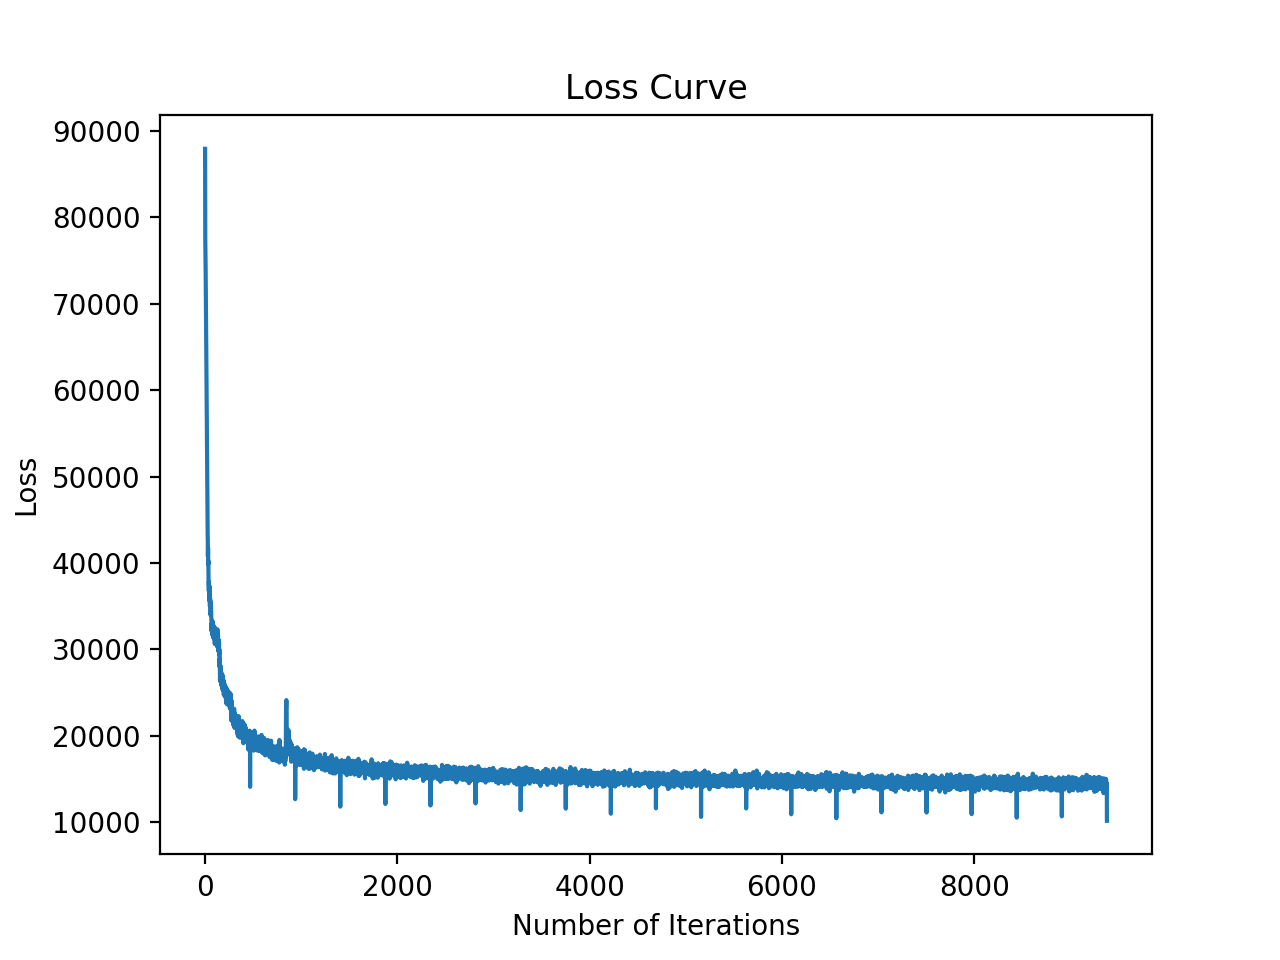

In [576]:
%matplotlib notebook
losses = []

# For each epoch
for epoch in range(epochs):
    
    # For each batch in the data loader
    for features, labels in train_data_loader:
        features = features.view(-1, 1, 28, 28)
        # Pass through the AutoEncoder
        output, mu, std = vae(features)

        # Reset optimiser gradients
        optimizer.zero_grad()
        
        # Calculate loss between AE output and input
        loss = criterion(output, features, mu, std)
        
        # Calculate gradients
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        losses.append(loss)
    
    print('Epoch %d: loss = %f' % (epoch, loss))
    
plt.plot(range(len(losses)), losses)
plt.title('Loss Curve')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.show()

## Using the VAE to generate deviations of seen digits in the dataset.

In [615]:
# Select five images from the data
images = X_train_tensor[255:260]
sample_images = np.zeros((140, 1))

# For each imag
for image in images:
    
    # Find the encoding
    sample_encoding, mu, std = vae.encode(image.reshape(-1, 1, 28, 28))
    
    # Duplicate the encoding five times
    sample_encodings = sample_encoding.repeat(5, 1)

    # Deviate the encodings using Gaussian noise
    sample_encodings = sample_encodings + 0.2*torch.randn_like(sample_encodings)

    # Decode the images.
    sample_image = vae.decode(sample_encodings).reshape(-1, 28).detach().numpy()
    
    sample_images = np.c_[sample_images, sample_image]
    

<IPython.core.display.Javascript object>


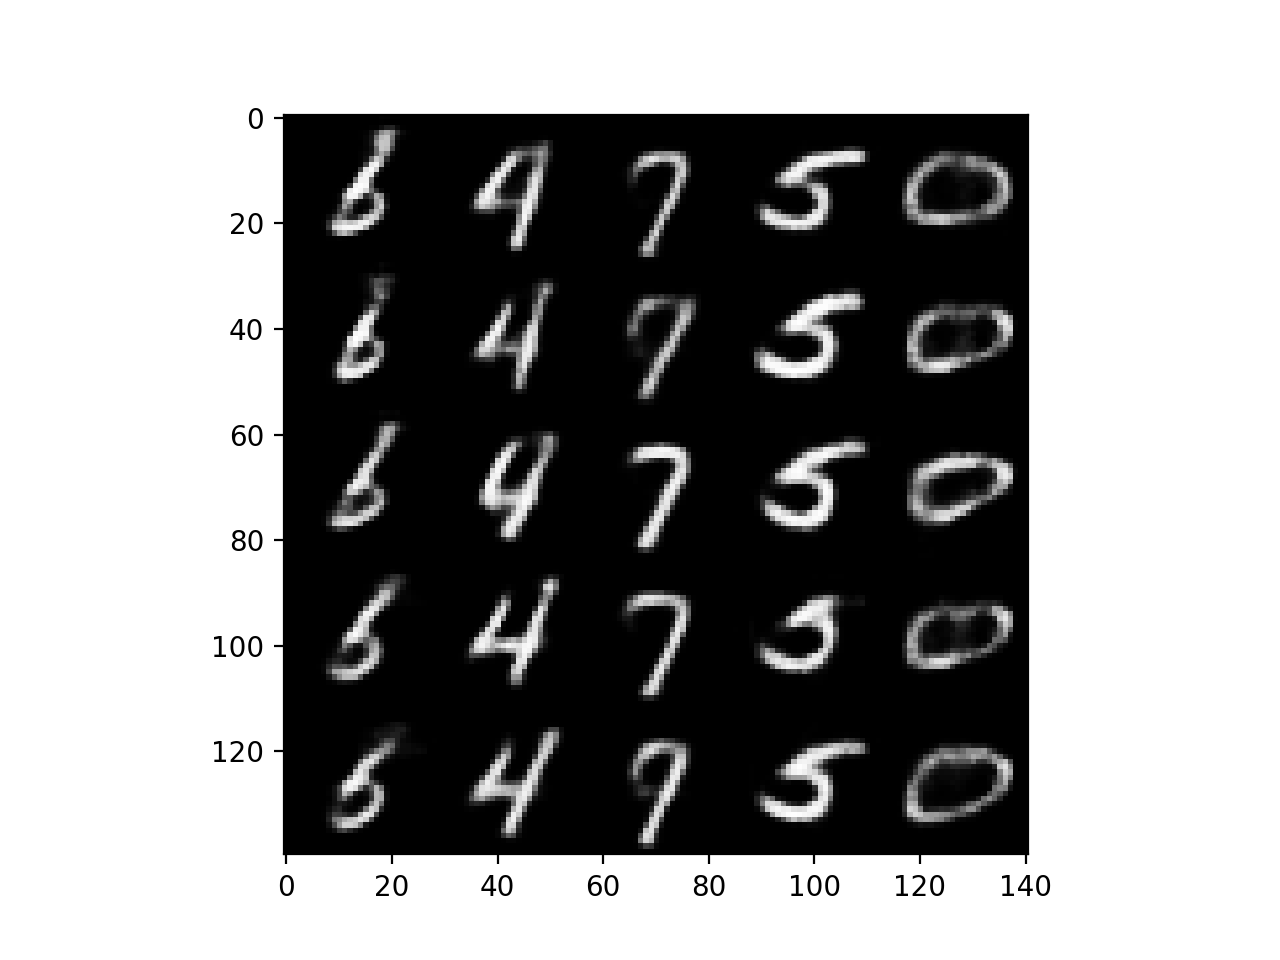

In [616]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.imshow(sample_images, cmap='gray')
plt.show()

## Using the VAE to generate digits by random sampling

<IPython.core.display.Javascript object>


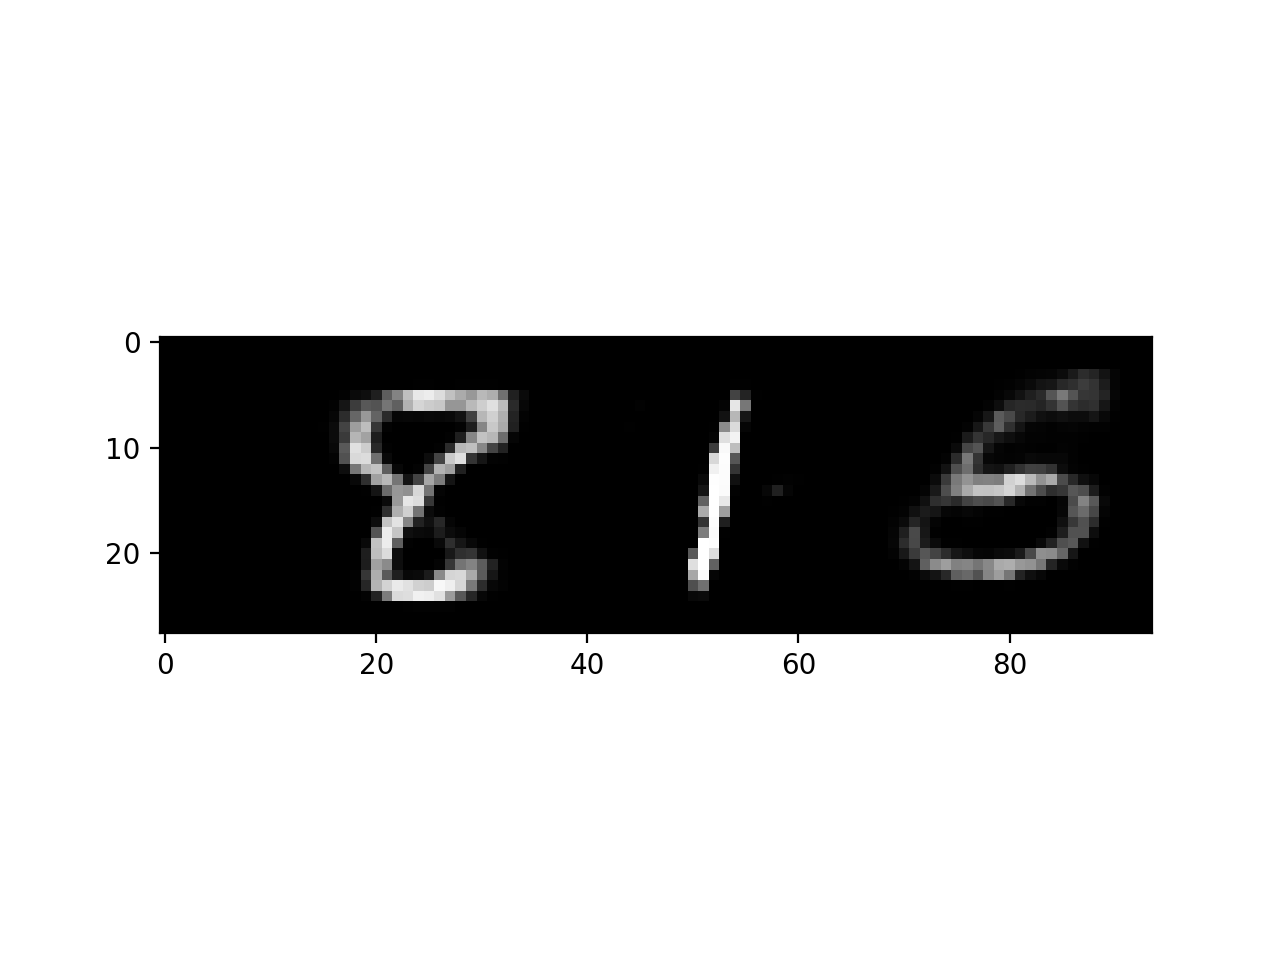

In [645]:
%matplotlib notebook

images = X_train_tensor[255:260]
sample_images = np.zeros((28, 10))

for i in range(3):
    e = torch.randn((1, 20))

    sample_image = vae.decode(e).reshape(-1, 28).detach().numpy()
    sample_images = np.c_[sample_images, sample_image]

plt.imshow(sample_images, cmap='gray')
plt.show()